Test set accuracy: 1.00


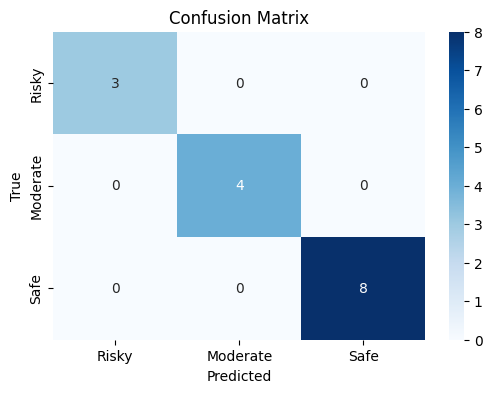

Classification Report:
              precision    recall  f1-score   support

       Risky       1.00      1.00      1.00         3
    Moderate       1.00      1.00      1.00         4
        Safe       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



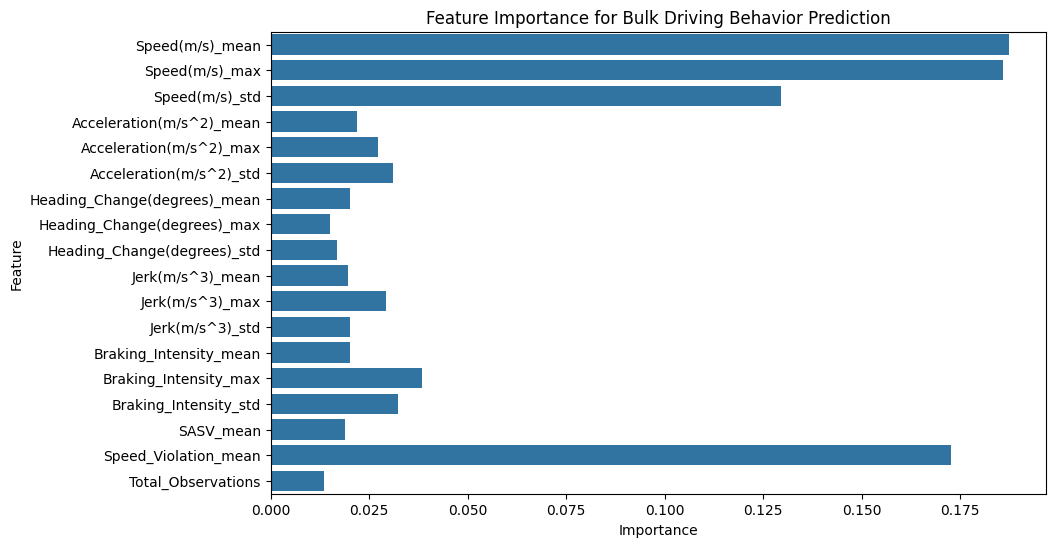

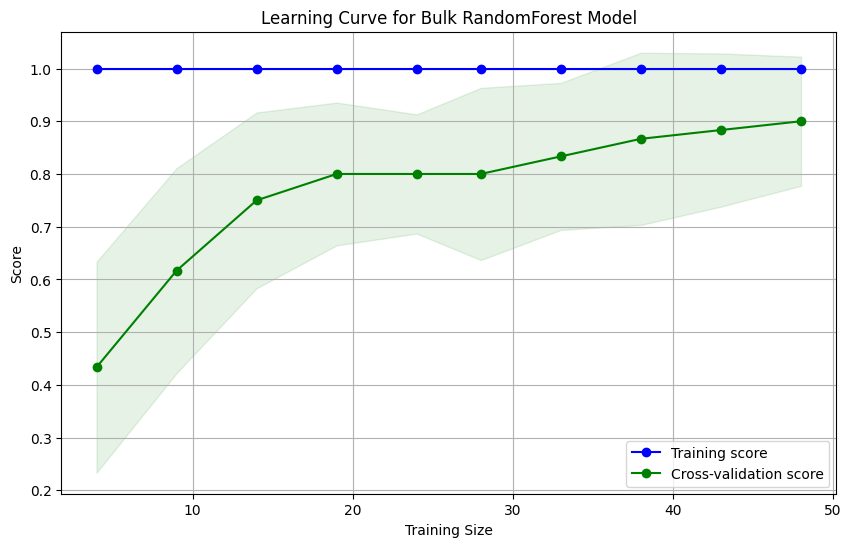

Model saved to ../models/bulk_driving_model.pkl


In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from imblearn.over_sampling import SMOTE

# Load the bulk aggregated data
aggregated_data_path = '../data/bulk_driver_aggregated_data.csv'
df = pd.read_csv(aggregated_data_path)

# Feature selection based on the columns in the dataset
X = df[['Speed(m/s)_mean', 'Speed(m/s)_max', 'Speed(m/s)_std',
        'Acceleration(m/s^2)_mean', 'Acceleration(m/s^2)_max', 'Acceleration(m/s^2)_std',
        'Heading_Change(degrees)_mean', 'Heading_Change(degrees)_max', 'Heading_Change(degrees)_std',
        'Jerk(m/s^3)_mean', 'Jerk(m/s^3)_max', 'Jerk(m/s^3)_std',
        'Braking_Intensity_mean', 'Braking_Intensity_max', 'Braking_Intensity_std',
        'SASV_mean', 'Speed_Violation_mean', 'Total_Observations']]

# Target variable: Driving Category (Risky, Moderate, Safe)
y = df['Driving_Category'].map({'Risky': 0, 'Moderate': 1, 'Safe': 2})

# Address class imbalance using SMOTE (Synthetic Minority Oversampling Technique)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
scaler_path = '../models/bulk_scaler.pkl'
with open(scaler_path, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

# Random Forest with class weighting
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Hyperparameter tuning with GridSearchCV or RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Stratified K-Fold Cross Validation to preserve class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Training the model
rf.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Safe'], 
            yticklabels=['Risky', 'Moderate', 'Safe'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Risky', 'Moderate', 'Safe']))

# Feature Importance
feature_importances = rf.feature_importances_
features = ['Speed(m/s)_mean', 'Speed(m/s)_max', 'Speed(m/s)_std',
            'Acceleration(m/s^2)_mean', 'Acceleration(m/s^2)_max', 'Acceleration(m/s^2)_std',
            'Heading_Change(degrees)_mean', 'Heading_Change(degrees)_max', 'Heading_Change(degrees)_std',
            'Jerk(m/s^3)_mean', 'Jerk(m/s^3)_max', 'Jerk(m/s^3)_std',
            'Braking_Intensity_mean', 'Braking_Intensity_max', 'Braking_Intensity_std',
            'SASV_mean', 'Speed_Violation_mean', 'Total_Observations']

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title('Feature Importance for Bulk Driving Behavior Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(rf, X_train_scaled, y_train, 
                                                        cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.1)
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve for Bulk RandomForest Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Save the trained model
model_filename = '../models/bulk_driving_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump(rf, model_file)

print(f"Model saved to {model_filename}")
